# ME5406 Deep Learning for Robotics - Project 1

## The Frozen Lake Problem and Variations

### Task 0 Import Required Libraries

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
print("Import library successfully")

Import library successfully


### Task 1.1 Monte Carlo Method

[2, 3, 3, 3, 2, 1, 2, 1, 4, 4, 2, 1, 1, 4, 4, 1]
Success!


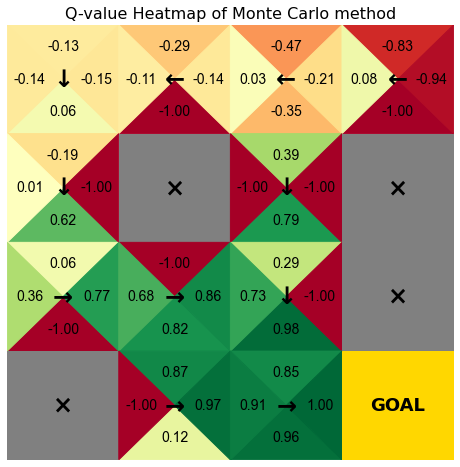

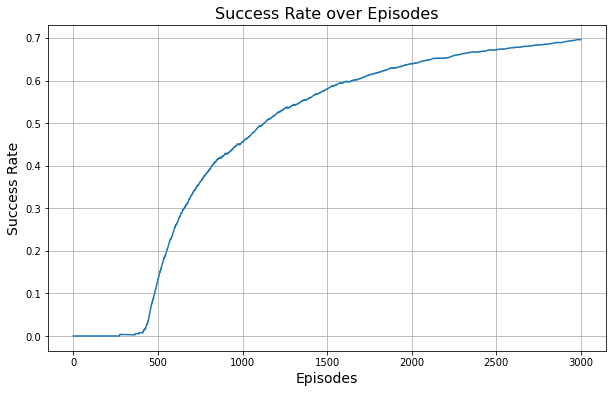

In [46]:
### Monte Carlo Method

env = [["s", "b", "b", "b"],
       ["b", "f", "b", "f"],
       ["b", "b", "b", "f"],
       ["f", "b", "b", "g"]]
episode = 3000
gamma = 0.99
epsilon = 0.15
policy_list = []
Q = [0 for _ in range(64)]
Q_times = [0 for _ in range(64)]
success_rate11 = []  # 记录成功率


def reward(i, j):
    if env[i][j] == "f":
        return -1
    elif env[i][j] == "g":
        return 1
    else:
        return 0


class Person:
    def __init__(self):
        self.i = 0
        self.j = 0


def greedy(p):
    num = random.random()
    index = p.i * 4 + p.j
    lst = Q[index * 4:index * 4 + 4]
    max_value = max(lst)
    best_actions = [a + 1 for a in range(4) if lst[a] == max_value]  # 找到所有最优动作
    if num < 1 - epsilon:
        return random.choice(best_actions)
    else:
        return random.randint(1, 4)


def loop():
    global epsilon
    success_count = 0  # 记录成功次数
    for t in range(episode):
        p = Person()
        s_list = [1]
        a_list = []
        while reward(p.i, p.j) == 0:
            if t == 0:
                a = random.randint(1, 4)
                move(p, a)
            else:
                a = greedy(p)
                move(p, a)
            a_list.append(a)
            s_list.append(p.i * 4 + p.j + 1)
        g_list = [0 for _ in range(len(s_list))]
        for k in range(len(s_list)):
            if k == 0:
                g_list[len(s_list) - k - 1] = 0
            else:
                g_list[len(s_list) - k - 1] = reward(p.i, p.j) * gamma ** (k - 1)

        for k in reversed(range(len(s_list) - 1)):
            a = a_list[k]
            s = s_list[k]
            Q[s * 4 + a - 5] = (Q[s * 4 + a - 5] * Q_times[s * 4 + a - 5] + g_list[k]) / (Q_times[s * 4 + a - 5] + 1)
            Q_times[s * 4 + a - 5] += 1
    
            # 记录成功率
        if reward(p.i, p.j) == 1:
            success_count += 1
        success_rate11.append(success_count / (t + 1))


def move(p, direction):
    if direction == 1 and p.i != 0:
        p.i += -1
    elif direction == 2 and p.i != 3:
        p.i += 1
    elif direction == 3 and p.j != 0:
        p.j += -1
    elif direction == 4 and p.j != 3:
        p.j += 1


def policy():
    for i in range(16):
        lst = Q[i * 4:i * 4 + 4]
        max_index = lst.index(max(lst)) + 1
        policy_list.append(max_index)
    print(policy_list)


def examine():
    p = Person()
    step = 0
    while reward(p.i, p.j) == 0 and step < 100:
        move(p, policy_list[p.i * 4 + p.j])
        step += 1
    if reward(p.i, p.j) == 1:
        print("Success!")
    elif reward(p.i, p.j) == -1:
        print("Fail!")
    else:
        print("Endless!")


# 策略动作映射
action_arrows = {1: "↑", 2: "↓", 3: "←", 4: "→"}

# 计算每个状态各个方向的 Q 值
def get_q_values():
    Q_values = np.zeros((4, 4, 4))  # 4x4网格, 每个网格有4个方向的Q值
    for i in range(4):
        for j in range(4):
            state_index = i * 4 + j
            Q_values[i, j, :] = Q[state_index * 4:state_index * 4 + 4]  # 获取4个方向的Q值
    return Q_values

# 画策略+Q值热力图（风车样式展示四个方向的Q值）
def plot_grid_policy():
    Q_values = get_q_values()  # 获取Q值矩阵
    fig, ax = plt.subplots(figsize=(8, 8))
    cmap = plt.cm.RdYlGn  # 热力颜色映射

    # 在每个格子上绘制策略箭头 & 特殊标记
    for i in range(4):
        for j in range(4):
            state_index = i * 4 + j

            # 特殊状态的固定颜色
            if env[i][j] == "f":  # 陷阱 (灰色)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gray')
                ax.add_patch(rect)
                ax.text(j, i, "×", ha="center", va="center", fontsize=24, fontweight="bold", color="black")

            elif env[i][j] == "g":  # 终点 (金色)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gold')
                ax.add_patch(rect)
                ax.text(j, i, "GOAL", ha="center", va="center", fontsize=18, fontweight="bold", color="black")

            else:
                # 获取当前状态四个方向的Q值
                q_up, q_down, q_left, q_right = Q_values[i, j]
                norm = plt.Normalize(vmin=-1, vmax=1)

                # 画上方小三角形 (↑)
                triangle_up = Polygon([[j, i], [j - 0.5, i - 0.5], [j + 0.5, i - 0.5]], 
                                      color=cmap(norm(q_up)))
                ax.add_patch(triangle_up)
                ax.text(j, i - 0.3, f"{q_up:.2f}", ha="center", va="center", fontsize=14, color="black",fontname='Arial')

                # 画下方小三角形 (↓)
                triangle_down = Polygon([[j, i], [j - 0.5, i + 0.5], [j + 0.5, i + 0.5]], 
                                        color=cmap(norm(q_down)))
                ax.add_patch(triangle_down)
                ax.text(j, i + 0.3, f"{q_down:.2f}", ha="center", va="center", fontsize=14, color="black",fontname='Arial')

                # 画左方小三角形 (←)
                triangle_left = Polygon([[j, i], [j - 0.5, i - 0.5], [j - 0.5, i + 0.5]], 
                                        color=cmap(norm(q_left)))
                ax.add_patch(triangle_left)
                ax.text(j - 0.3, i, f"{q_left:.2f}", ha="center", va="center", fontsize=14, color="black",fontname='Arial')

                # 画右方小三角形 (→)
                triangle_right = Polygon([[j, i], [j + 0.5, i - 0.5], [j + 0.5, i + 0.5]], 
                                         color=cmap(norm(q_right)))
                ax.add_patch(triangle_right)
                ax.text(j + 0.3, i, f"{q_right:.2f}", ha="center", va="center", fontsize=14, color="black",fontname='Arial')

                # 显示最优策略箭头
                best_action = policy_list[state_index]
                ax.text(j, i, action_arrows[best_action], ha="center", va="center", fontsize=24, fontweight="bold", color="black")

    # 设置图像格式
    ax.set_xticks(np.arange(-0.5, 4, 1))
    ax.set_yticks(np.arange(-0.5, 4, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis("off")  # 隐藏坐标轴

    plt.title("Q-value Heatmap of Monte Carlo method", fontsize=16)
    plt.gca().invert_yaxis()  # 使坐标原点在左下角
    plt.show()

def plot_success_rate():
    """绘制成功率变化图"""
    plt.figure(figsize=(10, 6))  # 设置图像大小，例如 10x6 英寸
    plt.plot(success_rate11)  # 让曲线更清晰
    plt.xlabel("Episodes", fontsize=14)  # 增大字体
    plt.ylabel("Success Rate", fontsize=14)
    plt.title("Success Rate over Episodes", fontsize=16)
    plt.grid(True)  # 添加网格以便观察趋势
    plt.show()


def main():
    loop()
    policy()
    examine()
    plot_grid_policy()
    plot_success_rate()

if __name__ == "__main__":
    main()



### Task 1.2 SARSA Method

[2, 3, 1, 1, 2, 1, 2, 1, 4, 2, 2, 1, 1, 4, 4, 1]
Success!


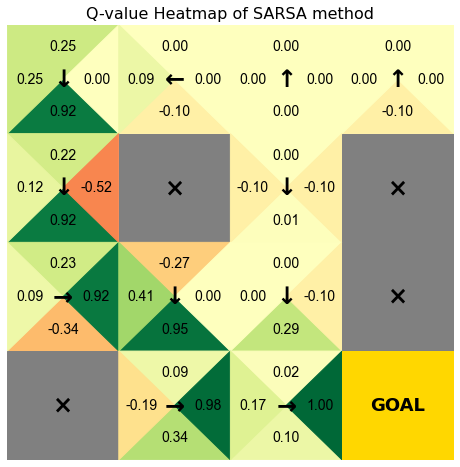

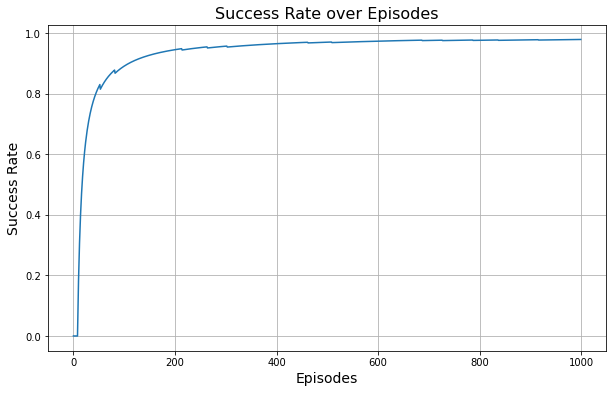

In [48]:
### SARSA Method
import random

env = [["s", "b", "b", "b"],
       ["b", "f", "b", "f"],
       ["b", "b", "b", "f"],
       ["f", "b", "b", "g"]]
episode = 1000
Q = [0 for _ in range(64)]
Q_times = [0 for _ in range(64)]
gamma = 0.99
epsilon = 0.01
alpha = 0.1
policy_list = []
success_rate12 = []  # 记录成功率

def reward(i, j):
    if env[i][j] == "f":
        return -1
    elif env[i][j] == "g":
        return 1
    else:
        return 0


class Person:
    def __init__(self):
        self.i = 0
        self.j = 0


def greedy(p):
    num = random.random()
    index = p.i * 4 + p.j
    lst = Q[index * 4:index * 4 + 4]
    max_value = max(lst)
    best_actions = [a + 1 for a in range(4) if lst[a] == max_value]  # 找到所有最优动作
    if num < 1 - epsilon:
        return random.choice(best_actions)
    else:
        return random.randint(1, 4)


def loop():
    global epsilon, alpha
    success_count = 0  # 记录成功次数
    for t in range(episode):
        p = Person()
        s_list = [1]
        a_list = []
        while reward(p.i, p.j) == 0:
            if t == 0:
                a = random.randint(1, 4)
                move(p, a)
            else:
                a = greedy(p)
                move(p, a)
            a_list.append(a)
            s_list.append(p.i * 4 + p.j + 1)

            if len(a_list) > 1:
                a0 = a_list[-2]
                a1 = a_list[-1]
                s0 = s_list[-3]
                s1 = s_list[-2]
                Q0 = Q[s0 * 4 + a0 - 5]
                Q1 = Q[s1 * 4 + a1 - 5]
                R = 0
                Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)
        a0 = a_list[-1]
        s0 = s_list[-2]
        s1 = s_list[-1]
        Q0 = Q[s0 * 4 + a0 - 5]
        Q1 = 0
        i = (s1 - 1) // 4
        j = (s1 - 1) % 4
        R = reward(i, j)
        Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)
        
        # 记录成功率
        if reward(p.i, p.j) == 1:
            success_count += 1
        success_rate12.append(success_count / (t + 1))


def move(p, direction):
    if direction == 1 and p.i != 0:
        p.i += -1
    elif direction == 2 and p.i != 3:
        p.i += 1
    elif direction == 3 and p.j != 0:
        p.j += -1
    elif direction == 4 and p.j != 3:
        p.j += 1


def policy():
    for i in range(16):
        lst = Q[i * 4:i * 4 + 4]
        max_index = lst.index(max(lst)) + 1
        policy_list.append(max_index)
    print(policy_list)


def examine():
    p = Person()
    step = 0
    while reward(p.i, p.j) == 0 and step < 100:
        move(p, policy_list[p.i * 4 + p.j])
        step += 1
    if reward(p.i, p.j) == 1:
        print("Success!")
    elif reward(p.i, p.j) == -1:
        print("Fail!")
    else:
        print("Endless!")


# 策略动作映射
action_arrows = {1: "↑", 2: "↓", 3: "←", 4: "→"}

# 计算每个状态各个方向的 Q 值
def get_q_values():
    Q_values = np.zeros((4, 4, 4))  # 4x4网格, 每个网格有4个方向的Q值
    for i in range(4):
        for j in range(4):
            state_index = i * 4 + j
            Q_values[i, j, :] = Q[state_index * 4:state_index * 4 + 4]  # 获取4个方向的Q值
    return Q_values

# 画策略+Q值热力图（风车样式展示四个方向的Q值）
def plot_grid_policy():
    Q_values = get_q_values()  # 获取Q值矩阵
    fig, ax = plt.subplots(figsize=(8, 8))
    cmap = plt.cm.RdYlGn  # 热力颜色映射

    # 在每个格子上绘制策略箭头 & 特殊标记
    for i in range(4):
        for j in range(4):
            state_index = i * 4 + j

            # 特殊状态的固定颜色
            if env[i][j] == "f":  # 陷阱 (灰色)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gray')
                ax.add_patch(rect)
                ax.text(j, i, "×", ha="center", va="center", fontsize=24, fontweight="bold", color="black")

            elif env[i][j] == "g":  # 终点 (金色)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gold')
                ax.add_patch(rect)
                ax.text(j, i, "GOAL", ha="center", va="center", fontsize=18, fontweight="bold", color="black")

            else:
                # 获取当前状态四个方向的Q值
                q_up, q_down, q_left, q_right = Q_values[i, j]
                norm = plt.Normalize(vmin=-1, vmax=1)

                # 画上方小三角形 (↑)
                triangle_up = Polygon([[j, i], [j - 0.5, i - 0.5], [j + 0.5, i - 0.5]], 
                                      color=cmap(norm(q_up)))
                ax.add_patch(triangle_up)
                ax.text(j, i - 0.3, f"{q_up:.2f}", ha="center", va="center", fontsize=14, color="black",fontname='Arial')

                # 画下方小三角形 (↓)
                triangle_down = Polygon([[j, i], [j - 0.5, i + 0.5], [j + 0.5, i + 0.5]], 
                                        color=cmap(norm(q_down)))
                ax.add_patch(triangle_down)
                ax.text(j, i + 0.3, f"{q_down:.2f}", ha="center", va="center", fontsize=14, color="black",fontname='Arial')

                # 画左方小三角形 (←)
                triangle_left = Polygon([[j, i], [j - 0.5, i - 0.5], [j - 0.5, i + 0.5]], 
                                        color=cmap(norm(q_left)))
                ax.add_patch(triangle_left)
                ax.text(j - 0.3, i, f"{q_left:.2f}", ha="center", va="center", fontsize=14, color="black",fontname='Arial')

                # 画右方小三角形 (→)
                triangle_right = Polygon([[j, i], [j + 0.5, i - 0.5], [j + 0.5, i + 0.5]], 
                                         color=cmap(norm(q_right)))
                ax.add_patch(triangle_right)
                ax.text(j + 0.3, i, f"{q_right:.2f}", ha="center", va="center", fontsize=14, color="black",fontname='Arial')

                # 显示最优策略箭头
                best_action = policy_list[state_index]
                ax.text(j, i, action_arrows[best_action], ha="center", va="center", fontsize=24, fontweight="bold", color="black")

    # 设置图像格式
    ax.set_xticks(np.arange(-0.5, 4, 1))
    ax.set_yticks(np.arange(-0.5, 4, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis("off")  # 隐藏坐标轴

    plt.title("Q-value Heatmap of SARSA method", fontsize=16)
    plt.gca().invert_yaxis()  # 使坐标原点在左下角
    plt.show()


def plot_success_rate():
    """绘制成功率变化图"""
    plt.figure(figsize=(10, 6))  # 设置图像大小，例如 10x6 英寸
    plt.plot(success_rate12)  # 让曲线更清晰
    plt.xlabel("Episodes", fontsize=14)  # 增大字体
    plt.ylabel("Success Rate", fontsize=14)
    plt.title("Success Rate over Episodes", fontsize=16)
    plt.grid(True)  # 添加网格以便观察趋势
    plt.show()

def main():
    loop()
    policy()
    examine()
    plot_grid_policy()
    plot_success_rate()

if __name__ == "__main__":
    main()


### Task 1.3 Q-learning Method

[4, 4, 2, 3, 1, 1, 2, 1, 1, 4, 2, 1, 1, 4, 4, 1]
Success!


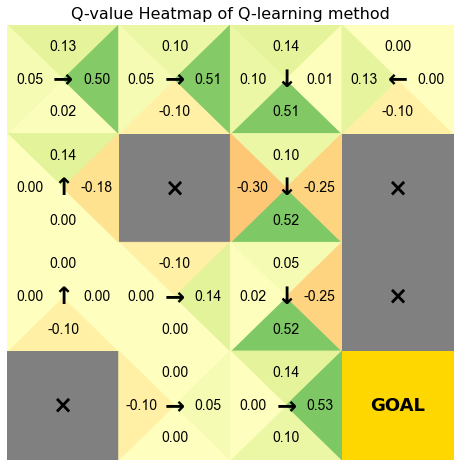

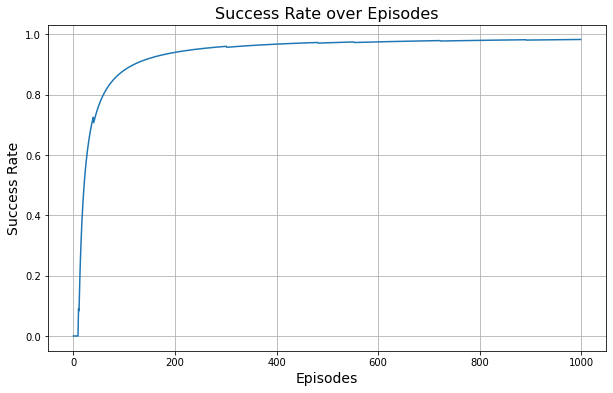

In [49]:
### Q-learning Method
import random

env = [["s", "b", "b", "b"],
       ["b", "f", "b", "f"],
       ["b", "b", "b", "f"],
       ["f", "b", "b", "g"]]
episode = 1000
Q = [0 for _ in range(64)]
Q_times = [0 for _ in range(64)]
gamma = 0.99
epsilon = 0.01
alpha = 0.1
policy_list = []
success_rate13 = []  # 记录成功率

def reward(i, j):
    if env[i][j] == "f":
        return -1
    elif env[i][j] == "g":
        return 1
    else:
        return 0


class Person:
    def __init__(self):
        self.i = 0
        self.j = 0


def greedy(p):
    num = random.random()
    index = p.i * 4 + p.j
    lst = Q[index * 4:index * 4 + 4]
    max_value = max(lst)
    best_actions = [a + 1 for a in range(4) if lst[a] == max_value]  # 找到所有最优动作
    if num < 1 - epsilon:
        return random.choice(best_actions)
    else:
        return random.randint(1, 4)


def loop():
    global epsilon, alpha
    success_count = 0  # 记录成功次数
    for t in range(episode):
        p = Person()
        s_list = [1]
        a_list = []
        while reward(p.i, p.j) == 0:
            if t == 0:
                a = random.randint(1, 4)
                move(p, a)
            else:
                a = greedy(p)
                move(p, a)
            a_list.append(a)
            s_list.append(p.i * 4 + p.j + 1)

            a0 = a_list[-1]
            # a1
            s0 = s_list[-2]
            s1 = s_list[-1]
            Q0 = Q[s0 * 4 + a0 - 5]
            Q1 = max(Q[s1 * 4 - 4:s1 * 4])
            R = 0
            Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)

        a0 = a_list[-1]
        # a1
        s0 = s_list[-2]
        s1 = s_list[-1]
        Q0 = Q[s0 * 4 + a0 - 5]
        Q1 = max(Q[s1 * 4 - 4:s1 * 4])
        R = reward(p.i, p.j)
        Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)
        
        # 记录成功率
        if reward(p.i, p.j) == 1:
            success_count += 1
        success_rate13.append(success_count / (t + 1))


def move(p, direction):
    if direction == 1 and p.i != 0:
        p.i += -1
    elif direction == 2 and p.i != 3:
        p.i += 1
    elif direction == 3 and p.j != 0:
        p.j += -1
    elif direction == 4 and p.j != 3:
        p.j += 1


def policy():
    for i in range(16):
        lst = Q[i * 4:i * 4 + 4]
        max_index = lst.index(max(lst)) + 1
        policy_list.append(max_index)
    print(policy_list)


def examine():
    p = Person()
    step = 0
    while reward(p.i, p.j) == 0 and step < 100:
        move(p, policy_list[p.i * 4 + p.j])
        step += 1
    if reward(p.i, p.j) == 1:
        print("Success!")
    elif reward(p.i, p.j) == -1:
        print("Fail!")
    else:
        print("Endless!")


# 策略动作映射
action_arrows = {1: "↑", 2: "↓", 3: "←", 4: "→"}

# 计算每个状态各个方向的 Q 值
def get_q_values():
    Q_values = np.zeros((4, 4, 4))  # 4x4网格, 每个网格有4个方向的Q值
    for i in range(4):
        for j in range(4):
            state_index = i * 4 + j
            Q_values[i, j, :] = Q[state_index * 4:state_index * 4 + 4]  # 获取4个方向的Q值
    return Q_values

# 画策略+Q值热力图（风车样式展示四个方向的Q值）
def plot_grid_policy():
    Q_values = get_q_values()  # 获取Q值矩阵
    fig, ax = plt.subplots(figsize=(8, 8))
    cmap = plt.cm.RdYlGn  # 热力颜色映射

    # 在每个格子上绘制策略箭头 & 特殊标记
    for i in range(4):
        for j in range(4):
            state_index = i * 4 + j

            # 特殊状态的固定颜色
            if env[i][j] == "f":  # 陷阱 (灰色)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gray')
                ax.add_patch(rect)
                ax.text(j, i, "×", ha="center", va="center", fontsize=24, fontweight="bold", color="black")

            elif env[i][j] == "g":  # 终点 (金色)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gold')
                ax.add_patch(rect)
                ax.text(j, i, "GOAL", ha="center", va="center", fontsize=18, fontweight="bold", color="black")

            else:
                # 获取当前状态四个方向的Q值
                q_up, q_down, q_left, q_right = Q_values[i, j]
                norm = plt.Normalize(vmin=-1, vmax=1)

                # 画上方小三角形 (↑)
                triangle_up = Polygon([[j, i], [j - 0.5, i - 0.5], [j + 0.5, i - 0.5]], 
                                      color=cmap(norm(q_up)))
                ax.add_patch(triangle_up)
                ax.text(j, i - 0.3, f"{q_up:.2f}", ha="center", va="center", fontsize=14, color="black",fontname='Arial')

                # 画下方小三角形 (↓)
                triangle_down = Polygon([[j, i], [j - 0.5, i + 0.5], [j + 0.5, i + 0.5]], 
                                        color=cmap(norm(q_down)))
                ax.add_patch(triangle_down)
                ax.text(j, i + 0.3, f"{q_down:.2f}", ha="center", va="center", fontsize=14, color="black",fontname='Arial')

                # 画左方小三角形 (←)
                triangle_left = Polygon([[j, i], [j - 0.5, i - 0.5], [j - 0.5, i + 0.5]], 
                                        color=cmap(norm(q_left)))
                ax.add_patch(triangle_left)
                ax.text(j - 0.3, i, f"{q_left:.2f}", ha="center", va="center", fontsize=14, color="black",fontname='Arial')

                # 画右方小三角形 (→)
                triangle_right = Polygon([[j, i], [j + 0.5, i - 0.5], [j + 0.5, i + 0.5]], 
                                         color=cmap(norm(q_right)))
                ax.add_patch(triangle_right)
                ax.text(j + 0.3, i, f"{q_right:.2f}", ha="center", va="center", fontsize=14, color="black",fontname='Arial')

                # 显示最优策略箭头
                best_action = policy_list[state_index]
                ax.text(j, i, action_arrows[best_action], ha="center", va="center", fontsize=24, fontweight="bold", color="black")

    # 设置图像格式
    ax.set_xticks(np.arange(-0.5, 4, 1))
    ax.set_yticks(np.arange(-0.5, 4, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis("off")  # 隐藏坐标轴

    plt.title("Q-value Heatmap of Q-learning method", fontsize=16)
    plt.gca().invert_yaxis()  # 使坐标原点在左下角
    plt.show()


def plot_success_rate():
    """绘制成功率变化图"""
    plt.figure(figsize=(10, 6))  # 设置图像大小，例如 10x6 英寸
    plt.plot(success_rate13)  # 让曲线更清晰
    plt.xlabel("Episodes", fontsize=14)  # 增大字体
    plt.ylabel("Success Rate", fontsize=14)
    plt.title("Success Rate over Episodes", fontsize=16)
    plt.grid(True)  # 添加网格以便观察趋势
    plt.show()

def main():
    loop()
    policy()
    examine()
    plot_grid_policy()
    plot_success_rate()

if __name__ == "__main__":
    main()

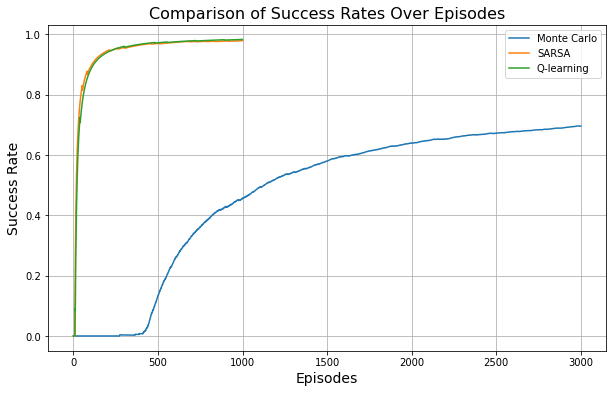

In [50]:
# 获取最长的长度
max_len = max(len(success_rate11), len(success_rate12), len(success_rate13))

# 创建x轴
episodes11 = np.arange(len(success_rate11))
episodes12 = np.arange(len(success_rate12))
episodes13 = np.arange(len(success_rate13))

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(episodes11, success_rate11, label="Monte Carlo")
plt.plot(episodes12, success_rate12, label="SARSA")
plt.plot(episodes13, success_rate13, label="Q-learning")

# 添加标题和标签
plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Success Rate", fontsize=14)
plt.title("Comparison of Success Rates Over Episodes", fontsize=16)
plt.legend()
plt.grid(True)

# 显示图像
plt.show()


### Task 2.1 Monte Carlo Method

[[4 2 1 3 4 3 3 1 1 1]
 [1 2 3 1 1 1 1 1 1 1]
 [2 3 1 1 1 1 3 1 1 1]
 [2 1 1 4 4 2 1 2 1 1]
 [4 2 3 4 2 3 3 3 1 2]
 [1 2 1 1 1 3 2 2 3 2]
 [4 2 3 1 2 1 1 2 2 2]
 [1 2 1 4 2 4 4 4 2 3]
 [2 4 2 1 2 3 4 4 2 2]
 [3 2 4 4 4 4 4 4 4 1]]
Success!


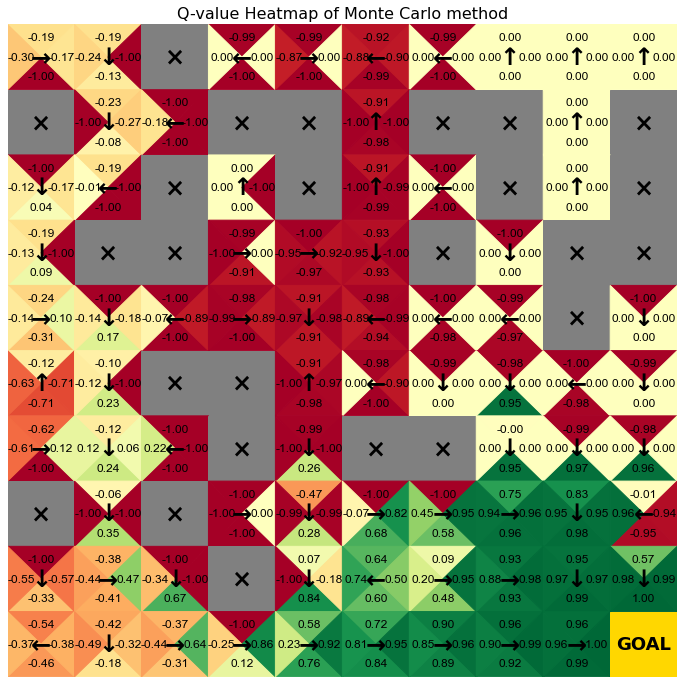

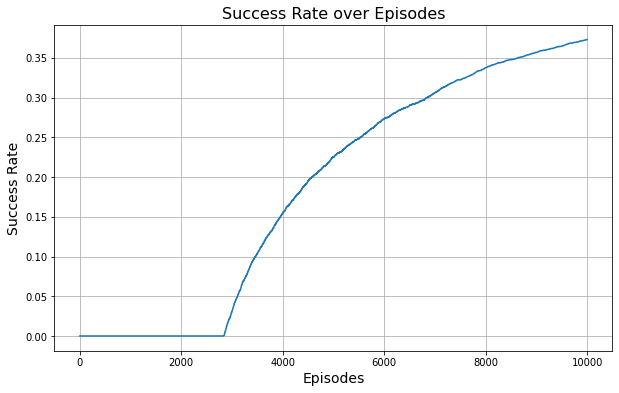

In [51]:
### Monte Carlo Method
import random
import numpy as np

env = [["s", "b", "f", "b", "b", "b", "b", "b", "b", "b"],
       ["f", "b", "b", "f", "f", "b", "f", "f", "b", "f"],
       ["b", "b", "f", "b", "f", "b", "b", "f", "b", "f"],
       ["b", "f", "f", "b", "b", "b", "f", "b", "f", "f"],
       ["b", "b", "b", "b", "b", "b", "b", "b", "f", "b"],
       ["b", "b", "f", "f", "b", "b", "b", "b", "b", "b"],
       ["b", "b", "b", "f", "b", "f", "f", "b", "b", "b"],
       ["f", "b", "f", "b", "b", "b", "b", "b", "b", "b"],
       ["b", "b", "b", "f", "b", "b", "b", "b", "b", "b"],
       ["b", "b", "b", "b", "b", "b", "b", "b", "b", "g"]]

episode = 10000
Q = [0 for _ in range(400)]
Q_times = [0 for _ in range(400)]
gamma = 0.99
epsilon = 0.15
policy_list = []
success_rate21 = []  # 记录成功率

def reward(i, j):
    # print(env[i][j], i * 4 + j + 1)
    if env[i][j] == "f":
        return -1
    elif env[i][j] == "g":
        return 1
    else:
        return 0


class Person:
    def __init__(self):
        self.i = 0
        self.j = 0


def greedy(p):
    num = random.random()
    index = p.i * 10 + p.j
    lst = Q[index * 4:index * 4 + 4]
    sorted_lst = sorted(lst, reverse=True)
    # max_value = max(lst)
    # best_actions = [a + 1 for a in range(4) if lst[a] == max_value]  # 找到所有最优动作
    # print(sorted_lst)
    # print(num)
    if num < 1 - epsilon:
        # return random.choice(best_actions)
        return lst.index(sorted_lst[0]) + 1
    else:
        return random.randint(1, 4)


def loop():
    global epsilon
    success_count = 0  # 记录成功次数
    for t in range(episode):
        p = Person()
        s_list = [1]
        a_list = []
        while reward(p.i, p.j) == 0:
            if t == 0:
                a = random.randint(1, 4)
                move(p, a)
            else:
                a = greedy(p)
                move(p, a)
            a_list.append(a)
            s_list.append(p.i * 10 + p.j + 1)
        g_list = [0 for _ in range(len(s_list))]
        for k in range(len(s_list)):
            if k == 0:
                g_list[len(s_list) - k - 1] = 0
            else:
                g_list[len(s_list) - k - 1] = reward(p.i, p.j) * gamma ** (k - 1)
        # print(g_list)
        check = []
        for k in reversed(range(len(s_list) - 1)):
            a = a_list[k]
            s = s_list[k]

            if s * 4 + a - 5 not in check:
                Q[s * 4 + a - 5] = (Q[s * 4 + a - 5] * Q_times[s * 4 + a - 5] + g_list[k]) / (
                            Q_times[s * 4 + a - 5] + 1)
                Q_times[s * 4 + a - 5] += 1
                check.append(s * 4 + a - 5)

            # 记录成功率
        if reward(p.i, p.j) == 1:
            success_count += 1
        success_rate21.append(success_count / (t + 1))



def move(p, direction):
    if direction == 1 and p.i != 0:
        p.i += -1
    elif direction == 2 and p.i != 9:
        p.i += 1
    elif direction == 3 and p.j != 0:
        p.j += -1
    elif direction == 4 and p.j != 9:
        p.j += 1


def policy():
    for i in range(100):
        lst = Q[i * 4:i * 4 + 4]
        max_index = lst.index(max(lst)) + 1
        policy_list.append(max_index)
    policy_matrix = np.array(policy_list).reshape(10, 10)
    print(policy_matrix)


def examine():
    p = Person()
    step = 0
    while reward(p.i, p.j) == 0 and step < 100:
        move(p, policy_list[p.i * 10 + p.j])
        step += 1
    if reward(p.i, p.j) == 1:
        print("Success!")
    elif reward(p.i, p.j) == -1:
        print("Fail!")
    else:
        print("Endless!")

# 策略动作映射
action_arrows = {1: "↑", 2: "↓",3: "←", 4: "→"}

# 计算每个状态各个方向的 Q 值
def get_q_values():
    Q_values = np.zeros((10, 10, 4))  # 4x4网格, 每个网格有4个方向的Q值
    for i in range(10):
        for j in range(10):
            state_index = i * 10 + j
            Q_values[i, j, :] = Q[state_index * 4:state_index * 4 + 4]  # 获取4个方向的Q值
    return Q_values

# 画策略+Q值热力图（风车样式展示四个方向的Q值）
def plot_grid_policy():
    Q_values = get_q_values()  # 获取Q值矩阵
    fig, ax = plt.subplots(figsize=(12, 12))
    cmap = plt.cm.RdYlGn  # 热力颜色映射

    # 在每个格子上绘制策略箭头 & 特殊标记
    for i in range(10):
        for j in range(10):
            state_index = i * 10 + j

            # 特殊状态的固定颜色
            if env[i][j] == "f":  # 陷阱 (灰色)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gray')
                ax.add_patch(rect)
                ax.text(j, i, "×", ha="center", va="center", fontsize=24, fontweight="bold", color="black")

            elif env[i][j] == "g":  # 终点 (金色)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gold')
                ax.add_patch(rect)
                ax.text(j, i, "GOAL", ha="center", va="center", fontsize=18, fontweight="bold", color="black")

            else:
                # 获取当前状态四个方向的Q值
                q_up,q_down,q_left, q_right = Q_values[i, j]
                norm = plt.Normalize(vmin=-1, vmax=1)

                # 画上方小三角形 (↑)
                triangle_up = Polygon([[j, i], [j - 0.5, i - 0.5], [j + 0.5, i - 0.5]], 
                                      color=cmap(norm(q_up)))
                ax.add_patch(triangle_up)
                ax.text(j, i - 0.3, f"{q_up:.2f}", ha="center", va="center", fontsize=12, color="black",fontname='Arial')

                # 画下方小三角形 (↓)
                triangle_down = Polygon([[j, i], [j - 0.5, i + 0.5], [j + 0.5, i + 0.5]], 
                                        color=cmap(norm(q_down)))
                ax.add_patch(triangle_down)
                ax.text(j, i + 0.3, f"{q_down:.2f}", ha="center", va="center", fontsize=12, color="black",fontname='Arial')

                # 画左方小三角形 (←)
                triangle_left = Polygon([[j, i], [j - 0.5, i - 0.5], [j - 0.5, i + 0.5]], 
                                        color=cmap(norm(q_left)))
                ax.add_patch(triangle_left)
                ax.text(j - 0.3, i, f"{q_left:.2f}", ha="center", va="center", fontsize=12, color="black",fontname='Arial')

                # 画右方小三角形 (→)
                triangle_right = Polygon([[j, i], [j + 0.5, i - 0.5], [j + 0.5, i + 0.5]], 
                                         color=cmap(norm(q_right)))
                ax.add_patch(triangle_right)
                ax.text(j + 0.3, i, f"{q_right:.2f}", ha="center", va="center", fontsize=12, color="black",fontname='Arial')

                # 显示最优策略箭头
                best_action = policy_list[state_index]
                ax.text(j, i, action_arrows[best_action], ha="center", va="center", fontsize=24, fontweight="bold", color="black")

    # 设置图像格式
    ax.set_xticks(np.arange(-0.5, 10, 1))
    ax.set_yticks(np.arange(-0.5, 10, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis("off")  # 隐藏坐标轴

    plt.title("Q-value Heatmap of Monte Carlo method", fontsize=16)
    plt.gca().invert_yaxis()  # 使坐标原点在左下角
    plt.show()


def plot_success_rate():
    """绘制成功率变化图"""
    plt.figure(figsize=(10, 6))  # 设置图像大小，例如 10x6 英寸
    plt.plot(success_rate21)  # 让曲线更清晰
    plt.xlabel("Episodes", fontsize=14)  # 增大字体
    plt.ylabel("Success Rate", fontsize=14)
    plt.title("Success Rate over Episodes", fontsize=16)
    plt.grid(True)  # 添加网格以便观察趋势
    plt.show()

def main():
    loop()
    policy()
    examine()
    plot_grid_policy()
    plot_success_rate()

if __name__ == "__main__":
    main()


### Task 2.2 SARSA Method

[[4 2 1 4 4 2 3 1 1 1]
 [1 2 3 1 1 2 1 1 1 1]
 [2 3 1 2 1 1 3 1 1 1]
 [2 1 1 4 4 1 1 2 1 1]
 [4 2 3 4 4 2 3 2 1 2]
 [1 2 1 1 4 1 3 4 2 2]
 [1 2 3 1 2 1 1 1 2 3]
 [1 2 1 2 2 2 2 1 2 1]
 [2 2 2 1 2 2 2 1 2 1]
 [4 4 4 4 4 4 4 1 4 1]]
Success!


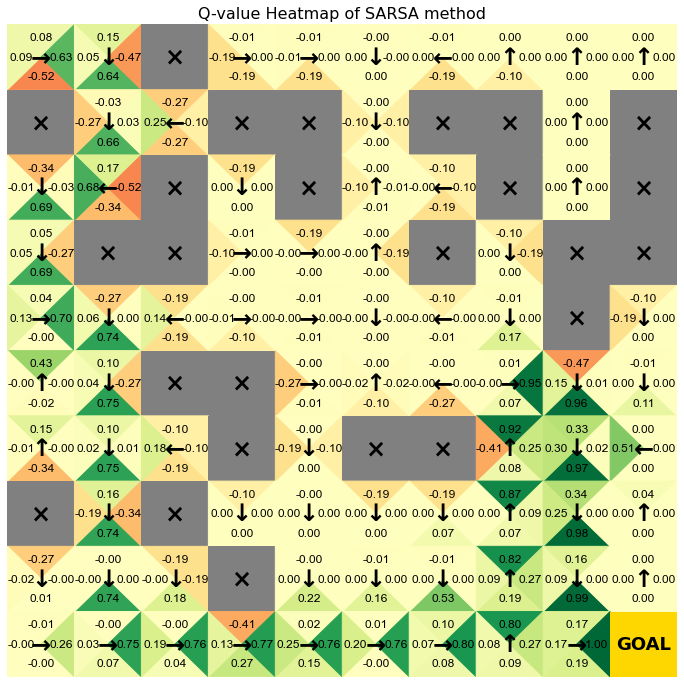

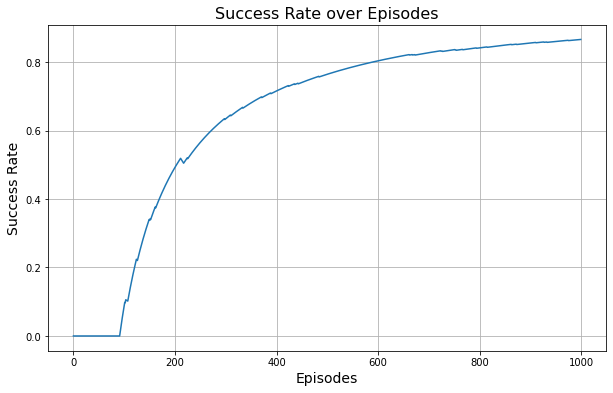

In [70]:
### SARSA Method
import random
import numpy as np

env = [["s", "b", "f", "b", "b", "b", "b", "b", "b", "b"],
       ["f", "b", "b", "f", "f", "b", "f", "f", "b", "f"],
       ["b", "b", "f", "b", "f", "b", "b", "f", "b", "f"],
       ["b", "f", "f", "b", "b", "b", "f", "b", "f", "f"],
       ["b", "b", "b", "b", "b", "b", "b", "b", "f", "b"],
       ["b", "b", "f", "f", "b", "b", "b", "b", "b", "b"],
       ["b", "b", "b", "f", "b", "f", "f", "b", "b", "b"],
       ["f", "b", "f", "b", "b", "b", "b", "b", "b", "b"],
       ["b", "b", "b", "f", "b", "b", "b", "b", "b", "b"],
       ["b", "b", "b", "b", "b", "b", "b", "b", "b", "g"]]

episode = 1000
Q = [0 for _ in range(400)]
Q_times = [0 for _ in range(400)]
gamma = 0.99
epsilon = 0.01
alpha = 0.1
policy_list = []
success_rate22 = []  # 记录成功率

def reward(i, j):
    # print(env[i][j], i * 4 + j + 1)
    if env[i][j] == "f":
        return -1
    elif env[i][j] == "g":
        return 1
    else:
        return 0


class Person:
    def __init__(self):
        self.i = 0
        self.j = 0


def greedy(p):
    num = random.random()
    index = p.i * 10 + p.j
    lst = Q[index * 4:index * 4 + 4]
    sorted_lst = sorted(lst, reverse=True)
    # max_value = max(lst)
    # best_actions = [a + 1 for a in range(4) if lst[a] == max_value]  # 找到所有最优动作
    # print(sorted_lst)
    # print(num)
    if num < 1 - epsilon:
        # return random.choice(best_actions)
        return lst.index(sorted_lst[0]) + 1
    else:
        return random.randint(1, 4)


def loop():
    global epsilon
    success_count = 0  # 记录成功次数
    for t in range(episode):
        p = Person()
        s_list = [1]
        a_list = []
        while reward(p.i, p.j) == 0:
            if t == 0:
                a = random.randint(1, 4)
                move(p, a)
            else:
                a = greedy(p)
                # print(a)
                move(p, a)
            a_list.append(a)
            s_list.append(p.i * 10 + p.j + 1)
            if len(a_list) > 1:
                a0 = a_list[-2]
                a1 = a_list[-1]
                s0 = s_list[-3]
                s1 = s_list[-2]
                Q0 = Q[s0 * 4 + a0 - 5]
                Q1 = Q[s1 * 4 + a1 - 5]
                R = 0
                Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)
            # print(p.i, p.j)
        a0 = a_list[-1]
        s0 = s_list[-2]
        s1 = s_list[-1]
        Q0 = Q[s0 * 4 + a0 - 5]
        Q1 = 0
        i = (s1 - 1) // 10
        j = (s1 - 1) % 10
        R = reward(i, j)
        Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)
        
        # 记录成功率
        if reward(p.i, p.j) == 1:
            success_count += 1
        success_rate22.append(success_count / (t + 1))



def move(p, direction):
    if direction == 1 and p.i != 0:
        p.i += -1
    elif direction == 2 and p.i != 9:
        p.i += 1
    elif direction == 3 and p.j != 0:
        p.j += -1
    elif direction == 4 and p.j != 9:
        p.j += 1


def policy():
    for i in range(100):
        lst = Q[i * 4:i * 4 + 4]
        max_index = lst.index(max(lst)) + 1
        policy_list.append(max_index)
    policy_matrix=np.array(policy_list).reshape(10, 10)
    print(policy_matrix)


def examine():
    p = Person()
    step = 0
    while reward(p.i, p.j) == 0 and step < 100:
        move(p, policy_list[p.i * 10 + p.j])
        step += 1
    if reward(p.i, p.j) == 1:
        print("Success!")
    elif reward(p.i, p.j) == -1:
        print("Fail!")
    else:
        print("Endless!")


# 策略动作映射
action_arrows = {1: "↑", 2: "↓",3: "←", 4: "→"}

# 计算每个状态各个方向的 Q 值
def get_q_values():
    Q_values = np.zeros((10, 10, 4))  # 4x4网格, 每个网格有4个方向的Q值
    for i in range(10):
        for j in range(10):
            state_index = i * 10 + j
            Q_values[i, j, :] = Q[state_index * 4:state_index * 4 + 4]  # 获取4个方向的Q值
    return Q_values

# 画策略+Q值热力图（风车样式展示四个方向的Q值）
def plot_grid_policy():
    Q_values = get_q_values()  # 获取Q值矩阵
    fig, ax = plt.subplots(figsize=(12, 12))
    cmap = plt.cm.RdYlGn  # 热力颜色映射

    # 在每个格子上绘制策略箭头 & 特殊标记
    for i in range(10):
        for j in range(10):
            state_index = i * 10 + j

            # 特殊状态的固定颜色
            if env[i][j] == "f":  # 陷阱 (灰色)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gray')
                ax.add_patch(rect)
                ax.text(j, i, "×", ha="center", va="center", fontsize=24, fontweight="bold", color="black")

            elif env[i][j] == "g":  # 终点 (金色)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gold')
                ax.add_patch(rect)
                ax.text(j, i, "GOAL", ha="center", va="center", fontsize=18, fontweight="bold", color="black")

            else:
                # 获取当前状态四个方向的Q值
                q_up,q_down,q_left, q_right = Q_values[i, j]
                norm = plt.Normalize(vmin=-1, vmax=1)

                # 画上方小三角形 (↑)
                triangle_up = Polygon([[j, i], [j - 0.5, i - 0.5], [j + 0.5, i - 0.5]], 
                                      color=cmap(norm(q_up)))
                ax.add_patch(triangle_up)
                ax.text(j, i - 0.3, f"{q_up:.2f}", ha="center", va="center", fontsize=12, color="black",fontname='Arial')

                # 画下方小三角形 (↓)
                triangle_down = Polygon([[j, i], [j - 0.5, i + 0.5], [j + 0.5, i + 0.5]], 
                                        color=cmap(norm(q_down)))
                ax.add_patch(triangle_down)
                ax.text(j, i + 0.3, f"{q_down:.2f}", ha="center", va="center", fontsize=12, color="black",fontname='Arial')

                # 画左方小三角形 (←)
                triangle_left = Polygon([[j, i], [j - 0.5, i - 0.5], [j - 0.5, i + 0.5]], 
                                        color=cmap(norm(q_left)))
                ax.add_patch(triangle_left)
                ax.text(j - 0.3, i, f"{q_left:.2f}", ha="center", va="center", fontsize=12, color="black",fontname='Arial')

                # 画右方小三角形 (→)
                triangle_right = Polygon([[j, i], [j + 0.5, i - 0.5], [j + 0.5, i + 0.5]], 
                                         color=cmap(norm(q_right)))
                ax.add_patch(triangle_right)
                ax.text(j + 0.3, i, f"{q_right:.2f}", ha="center", va="center", fontsize=12, color="black",fontname='Arial')

                # 显示最优策略箭头
                best_action = policy_list[state_index]
                ax.text(j, i, action_arrows[best_action], ha="center", va="center", fontsize=24, fontweight="bold", color="black")

    # 设置图像格式
    ax.set_xticks(np.arange(-0.5, 10, 1))
    ax.set_yticks(np.arange(-0.5, 10, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis("off")  # 隐藏坐标轴

    plt.title("Q-value Heatmap of SARSA method", fontsize=16)
    plt.gca().invert_yaxis()  # 使坐标原点在左下角
    plt.show()

def plot_success_rate():
    """绘制成功率变化图"""
    plt.figure(figsize=(10, 6))  # 设置图像大小，例如 10x6 英寸
    plt.plot(success_rate22)  # 让曲线更清晰
    plt.xlabel("Episodes", fontsize=14)  # 增大字体
    plt.ylabel("Success Rate", fontsize=14)
    plt.title("Success Rate over Episodes", fontsize=16)
    plt.grid(True)  # 添加网格以便观察趋势
    plt.show()

def main():
    loop()
    policy()
    examine()
    plot_grid_policy()
    plot_success_rate()

if __name__ == "__main__":
    main()


### Task 2.3 Q-learning Method

[[4 2 1 1 1 1 1 1 1 1]
 [1 2 3 1 1 1 1 1 1 1]
 [2 3 1 2 1 1 3 1 1 1]
 [2 1 1 1 2 1 1 2 1 1]
 [2 3 3 1 1 1 2 1 1 2]
 [2 2 1 1 1 1 1 1 2 1]
 [4 2 3 1 1 1 1 1 1 1]
 [1 2 1 4 1 2 2 1 1 1]
 [2 2 2 1 2 2 3 2 3 1]
 [4 4 4 4 4 4 4 4 4 1]]
Success!


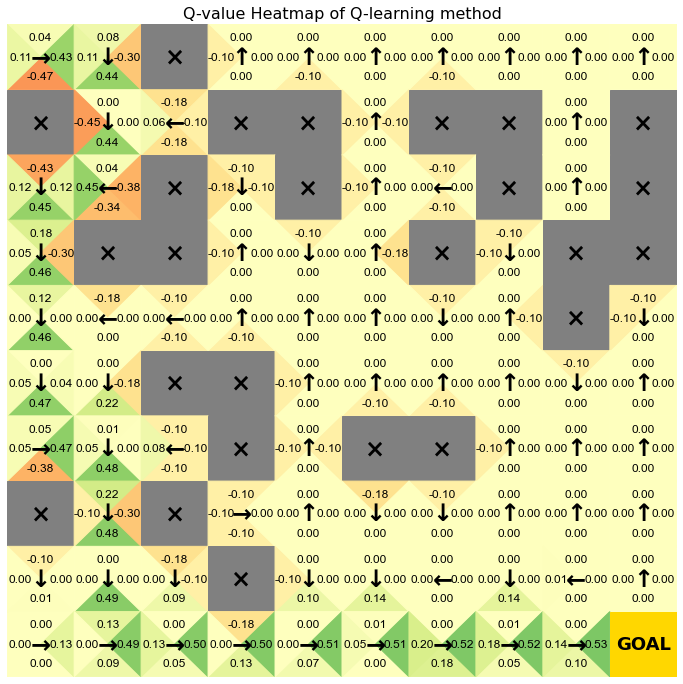

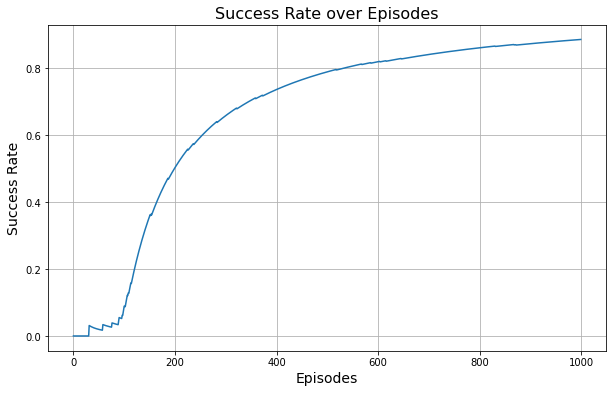

In [71]:
### Q-learning Method
import random
import numpy as np

env = [["s", "b", "f", "b", "b", "b", "b", "b", "b", "b"],
       ["f", "b", "b", "f", "f", "b", "f", "f", "b", "f"],
       ["b", "b", "f", "b", "f", "b", "b", "f", "b", "f"],
       ["b", "f", "f", "b", "b", "b", "f", "b", "f", "f"],
       ["b", "b", "b", "b", "b", "b", "b", "b", "f", "b"],
       ["b", "b", "f", "f", "b", "b", "b", "b", "b", "b"],
       ["b", "b", "b", "f", "b", "f", "f", "b", "b", "b"],
       ["f", "b", "f", "b", "b", "b", "b", "b", "b", "b"],
       ["b", "b", "b", "f", "b", "b", "b", "b", "b", "b"],
       ["b", "b", "b", "b", "b", "b", "b", "b", "b", "g"]]

episode = 1000
Q = [0 for _ in range(400)]
Q_times = [0 for _ in range(400)]
gamma = 0.99
epsilon = 0.01
alpha = 0.1
policy_list = []
success_rate23 = []  # 记录成功率

def reward(i, j):
    # print(env[i][j], i * 4 + j + 1)
    if env[i][j] == "f":
        return -1
    elif env[i][j] == "g":
        return 1
    else:
        return 0


class Person:
    def __init__(self):
        self.i = 0
        self.j = 0


def greedy(p):
    num = random.random()
    index = p.i * 10 + p.j
    lst = Q[index * 4:index * 4 + 4]
    sorted_lst = sorted(lst, reverse=True)
    max_value = max(lst)
    best_actions = [a + 1 for a in range(4) if lst[a] == max_value]  # 找到所有最优动作
    # print(sorted_lst)
    # print(num)
    if num < 1 - epsilon:
        return random.choice(best_actions)
        # return lst.index(sorted_lst[0]) + 1
    else:
        return random.randint(1, 4)


def loop():
    global epsilon
    success_count = 0  # 记录成功次数
    for t in range(episode):
        p = Person()
        s_list = [1]
        a_list = []
        while reward(p.i, p.j) == 0:
            if t == 0:
                a = random.randint(1, 4)
                move(p, a)
            else:
                a = greedy(p)
                move(p, a)
            a_list.append(a)
            s_list.append(p.i * 10 + p.j + 1)

            a0 = a_list[-1]
            # a1
            s0 = s_list[-2]
            s1 = s_list[-1]
            Q0 = Q[s0 * 4 + a0 - 5]
            Q1 = max(Q[s1 * 4 - 4:s1 * 4])
            R = 0
            Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)

        a0 = a_list[-1]
        # a1
        s0 = s_list[-2]
        s1 = s_list[-1]
        Q0 = Q[s0 * 4 + a0 - 5]
        Q1 = max(Q[s1 * 4 - 4:s1 * 4])
        R = reward(p.i, p.j)
        Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)
        
        # 记录成功率
        if reward(p.i, p.j) == 1:
            success_count += 1
        success_rate23.append(success_count / (t + 1))



def move(p, direction):
    if direction == 1 and p.i != 0:
        p.i += -1
    elif direction == 2 and p.i != 9:
        p.i += 1
    elif direction == 3 and p.j != 0:
        p.j += -1
    elif direction == 4 and p.j != 9:
        p.j += 1


def policy():
    for i in range(100):
        lst = Q[i * 4:i * 4 + 4]
        max_index = lst.index(max(lst)) + 1
        policy_list.append(max_index)
    policy_matrix=np.array(policy_list).reshape(10, 10)
    print(policy_matrix)


def examine():
    p = Person()
    step = 0
    while reward(p.i, p.j) == 0 and step < 100:
        move(p, policy_list[p.i * 10 + p.j])
        step += 1
    if reward(p.i, p.j) == 1:
        print("Success!")
    elif reward(p.i, p.j) == -1:
        print("Fail!")
    else:
        print("Endless!")


# 策略动作映射
action_arrows = {1: "↑", 2: "↓",3: "←", 4: "→"}

# 计算每个状态各个方向的 Q 值
def get_q_values():
    Q_values = np.zeros((10, 10, 4))  # 4x4网格, 每个网格有4个方向的Q值
    for i in range(10):
        for j in range(10):
            state_index = i * 10 + j
            Q_values[i, j, :] = Q[state_index * 4:state_index * 4 + 4]  # 获取4个方向的Q值
    return Q_values

# 画策略+Q值热力图（风车样式展示四个方向的Q值）
def plot_grid_policy():
    Q_values = get_q_values()  # 获取Q值矩阵
    fig, ax = plt.subplots(figsize=(12, 12))
    cmap = plt.cm.RdYlGn  # 热力颜色映射

    # 在每个格子上绘制策略箭头 & 特殊标记
    for i in range(10):
        for j in range(10):
            state_index = i * 10 + j

            # 特殊状态的固定颜色
            if env[i][j] == "f":  # 陷阱 (灰色)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gray')
                ax.add_patch(rect)
                ax.text(j, i, "×", ha="center", va="center", fontsize=24, fontweight="bold", color="black")

            elif env[i][j] == "g":  # 终点 (金色)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gold')
                ax.add_patch(rect)
                ax.text(j, i, "GOAL", ha="center", va="center", fontsize=18, fontweight="bold", color="black")

            else:
                # 获取当前状态四个方向的Q值
                q_up,q_down,q_left, q_right = Q_values[i, j]
                norm = plt.Normalize(vmin=-1, vmax=1)

                # 画上方小三角形 (↑)
                triangle_up = Polygon([[j, i], [j - 0.5, i - 0.5], [j + 0.5, i - 0.5]], 
                                      color=cmap(norm(q_up)))
                ax.add_patch(triangle_up)
                ax.text(j, i - 0.3, f"{q_up:.2f}", ha="center", va="center", fontsize=12, color="black",fontname='Arial')

                # 画下方小三角形 (↓)
                triangle_down = Polygon([[j, i], [j - 0.5, i + 0.5], [j + 0.5, i + 0.5]], 
                                        color=cmap(norm(q_down)))
                ax.add_patch(triangle_down)
                ax.text(j, i + 0.3, f"{q_down:.2f}", ha="center", va="center", fontsize=12, color="black",fontname='Arial')

                # 画左方小三角形 (←)
                triangle_left = Polygon([[j, i], [j - 0.5, i - 0.5], [j - 0.5, i + 0.5]], 
                                        color=cmap(norm(q_left)))
                ax.add_patch(triangle_left)
                ax.text(j - 0.3, i, f"{q_left:.2f}", ha="center", va="center", fontsize=12, color="black",fontname='Arial')

                # 画右方小三角形 (→)
                triangle_right = Polygon([[j, i], [j + 0.5, i - 0.5], [j + 0.5, i + 0.5]], 
                                         color=cmap(norm(q_right)))
                ax.add_patch(triangle_right)
                ax.text(j + 0.3, i, f"{q_right:.2f}", ha="center", va="center", fontsize=12, color="black",fontname='Arial')

                # 显示最优策略箭头
                best_action = policy_list[state_index]
                ax.text(j, i, action_arrows[best_action], ha="center", va="center", fontsize=24, fontweight="bold", color="black")

    # 设置图像格式
    ax.set_xticks(np.arange(-0.5, 10, 1))
    ax.set_yticks(np.arange(-0.5, 10, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis("off")  # 隐藏坐标轴

    plt.title("Q-value Heatmap of Q-learning method", fontsize=16)
    plt.gca().invert_yaxis()  # 使坐标原点在左下角
    plt.show()


def plot_success_rate():
    """绘制成功率变化图"""
    plt.figure(figsize=(10, 6))  # 设置图像大小，例如 10x6 英寸
    plt.plot(success_rate23)  # 让曲线更清晰
    plt.xlabel("Episodes", fontsize=14)  # 增大字体
    plt.ylabel("Success Rate", fontsize=14)
    plt.title("Success Rate over Episodes", fontsize=16)
    plt.grid(True)  # 添加网格以便观察趋势
    plt.show()

def main():
    loop()
    policy()
    examine()
    plot_grid_policy()
    plot_success_rate()

if __name__ == "__main__":
    main()


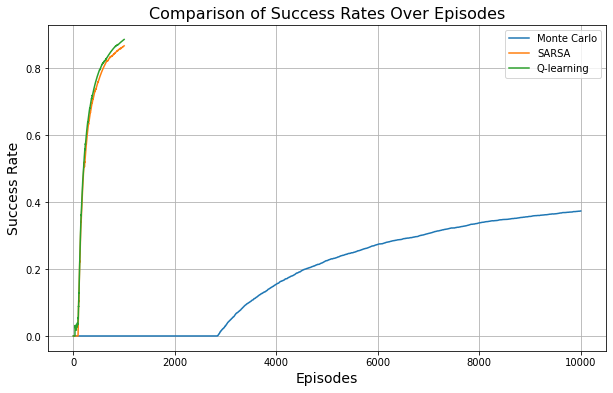

In [72]:
# 获取最长的长度
max_len = max(len(success_rate21), len(success_rate22), len(success_rate23))

# 创建x轴
episodes21 = np.arange(len(success_rate21))
episodes22 = np.arange(len(success_rate22))
episodes23 = np.arange(len(success_rate23))

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(episodes21, success_rate21, label="Monte Carlo")
plt.plot(episodes22, success_rate22, label="SARSA")
plt.plot(episodes23, success_rate23, label="Q-learning")

# 添加标题和标签
plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Success Rate", fontsize=14)
plt.title("Comparison of Success Rates Over Episodes", fontsize=16)
plt.legend()
plt.grid(True)

# 显示图像
plt.show()